In [ ]:
!unzip -q "archive.zip"

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from skimage.filters import sobel,gaussian
from skimage.transform import rotate,resize
from skimage.exposure import equalize_hist
from skimage.restoration import denoise_tv_chambolle
from skimage.color import rgb2gray
from sklearn.metrics import plot_confusion_matrix,classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from random import randint,seed

In [ ]:
seed=42
df=pd.read_csv('age_gender.csv')
df

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...
...,...,...,...,...,...
23700,99,0,1,20170120221920654.jpg.chip.jpg,127 100 94 81 77 77 74 99 102 98 128 145 160 1...
23701,99,1,1,20170120134639935.jpg.chip.jpg,23 28 32 35 42 47 68 85 98 103 113 117 130 129...
23702,99,2,1,20170110182418864.jpg.chip.jpg,59 50 37 40 34 19 30 101 156 170 177 184 187 1...
23703,99,2,1,20170117195405372.jpg.chip.jpg,45 108 120 156 206 197 140 180 191 199 204 207...


In [ ]:
df.drop('img_name',inplace=True,axis=1)

In [ ]:
df.isnull().sum()

age          0
ethnicity    0
gender       0
pixels       0
dtype: int64

In [ ]:
df.nunique()

age            104
ethnicity        5
gender           2
pixels       23315
dtype: int64

In [ ]:
df.sort_values('age',inplace=True)
df

,age,ethnicity,gender,pixels
0,1,2,0,129 128 128 126 127 130 133 135 139 142 145 14...
740,1,2,1,172 186 196 203 212 210 208 204 197 189 182 17...
741,1,2,1,177 174 171 167 164 159 155 140 171 179 183 18...
742,1,2,1,77 89 98 101 102 105 104 105 91 98 105 110 111...
743,1,2,1,171 172 175 177 178 178 180 183 183 185 185 18...
...,...,...,...,...
1371,115,0,1,170 153 145 141 133 140 141 146 144 150 171 17...
1373,116,2,1,207 200 197 181 186 174 184 185 162 164 164 16...
1375,116,0,1,105 86 95 135 159 150 147 147 153 117 148 160 ...
1372,116,0,1,81 91 101 106 113 115 117 121 122 122 122 128 ...


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


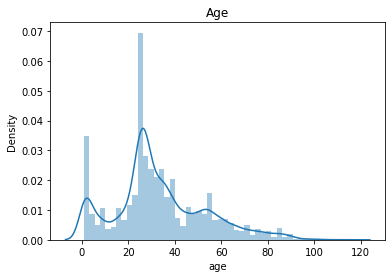

In [ ]:
plt.title('Age')
sns.distplot(df.age)

In [ ]:
df["age"] = pd.cut(df["age"],bins=[0,3,18,40,70,116],labels=["0","1","2","3","4"])

In [ ]:
len(df['pixels'][0].split())

2304

In [ ]:
#2304 pixels --> 48*48
h=w=48
df['pixels']=df['pixels'].apply(lambda x:np.array(x.split(),dtype='float').reshape(h,w))

In [ ]:
df

,age,ethnicity,gender,pixels
0,0,2,0,"[[129.0, 128.0, 128.0, 126.0, 127.0, 130.0, 13..."
740,0,2,1,"[[172.0, 186.0, 196.0, 203.0, 212.0, 210.0, 20..."
741,0,2,1,"[[177.0, 174.0, 171.0, 167.0, 164.0, 159.0, 15..."
742,0,2,1,"[[77.0, 89.0, 98.0, 101.0, 102.0, 105.0, 104.0..."
743,0,2,1,"[[171.0, 172.0, 175.0, 177.0, 178.0, 178.0, 18..."
...,...,...,...,...
1371,4,0,1,"[[170.0, 153.0, 145.0, 141.0, 133.0, 140.0, 14..."
1373,4,2,1,"[[207.0, 200.0, 197.0, 181.0, 186.0, 174.0, 18..."
1375,4,0,1,"[[105.0, 86.0, 95.0, 135.0, 159.0, 150.0, 147...."
1372,4,0,1,"[[81.0, 91.0, 101.0, 106.0, 113.0, 115.0, 117...."


Data Visualization

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23705 entries, 0 to 1374
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   age        23705 non-null  category
 1   ethnicity  23705 non-null  int64   
 2   gender     23705 non-null  int64   
 3   pixels     23705 non-null  object  
dtypes: category(1), int64(2), object(1)
memory usage: 1.4+ MB


In [ ]:
gender_labels={0:'Male',1:'Female'}
age_labels={0:'0 to 3',1:'3 to 18',2:'18 to 40',3:'40 to 70',4:'70 to 116'}
ethnicity_labels={0:"White", 1:"Black", 2:"Asian", 3:"Indian", 4:"Hispanic"}

In [ ]:
df['age_labels']=df['age'].map(age_labels)
df['gender_labels']=df['gender'].map(gender_labels)
df['ethnicity_labels']=df['ethnicity'].map(ethnicity_labels)
df

,age,ethnicity,gender,pixels,age_labels,gender_labels,ethnicity_labels
0,0,2,0,"[[129.0, 128.0, 128.0, 126.0, 127.0, 130.0, 13...",0 to 3,Male,Asian
740,0,2,1,"[[172.0, 186.0, 196.0, 203.0, 212.0, 210.0, 20...",0 to 3,Female,Asian
741,0,2,1,"[[177.0, 174.0, 171.0, 167.0, 164.0, 159.0, 15...",0 to 3,Female,Asian
742,0,2,1,"[[77.0, 89.0, 98.0, 101.0, 102.0, 105.0, 104.0...",0 to 3,Female,Asian
743,0,2,1,"[[171.0, 172.0, 175.0, 177.0, 178.0, 178.0, 18...",0 to 3,Female,Asian
...,...,...,...,...,...,...,...
1371,4,0,1,"[[170.0, 153.0, 145.0, 141.0, 133.0, 140.0, 14...",70 to 116,Female,White
1373,4,2,1,"[[207.0, 200.0, 197.0, 181.0, 186.0, 174.0, 18...",70 to 116,Female,Asian
1375,4,0,1,"[[105.0, 86.0, 95.0, 135.0, 159.0, 150.0, 147....",70 to 116,Female,White
1372,4,0,1,"[[81.0, 91.0, 101.0, 106.0, 113.0, 115.0, 117....",70 to 116,Female,White


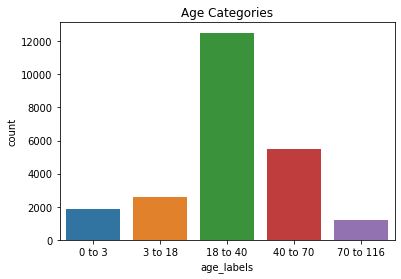

In [ ]:
plt.title('Age Categories')
sns.countplot(x='age_labels', data=df)

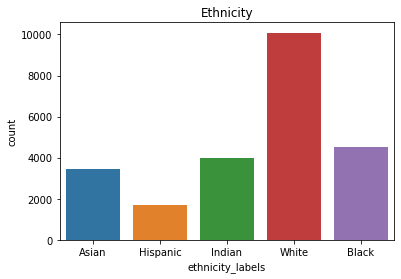

In [ ]:
plt.title('Ethnicity')
sns.countplot(x='ethnicity_labels', data=df)

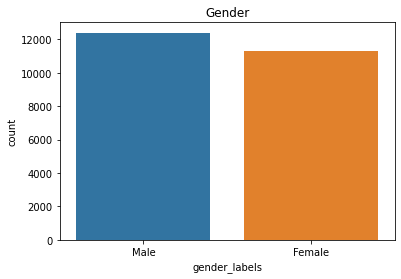

In [ ]:
plt.title('Gender')
sns.countplot(x='gender_labels', data=df)

Showing some samples

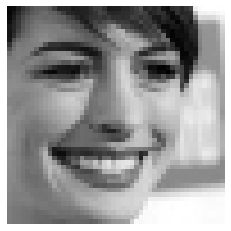

In [ ]:
plt.gray()
plt.axis('off')
pic1=plt.imshow(df['pixels'][11334])

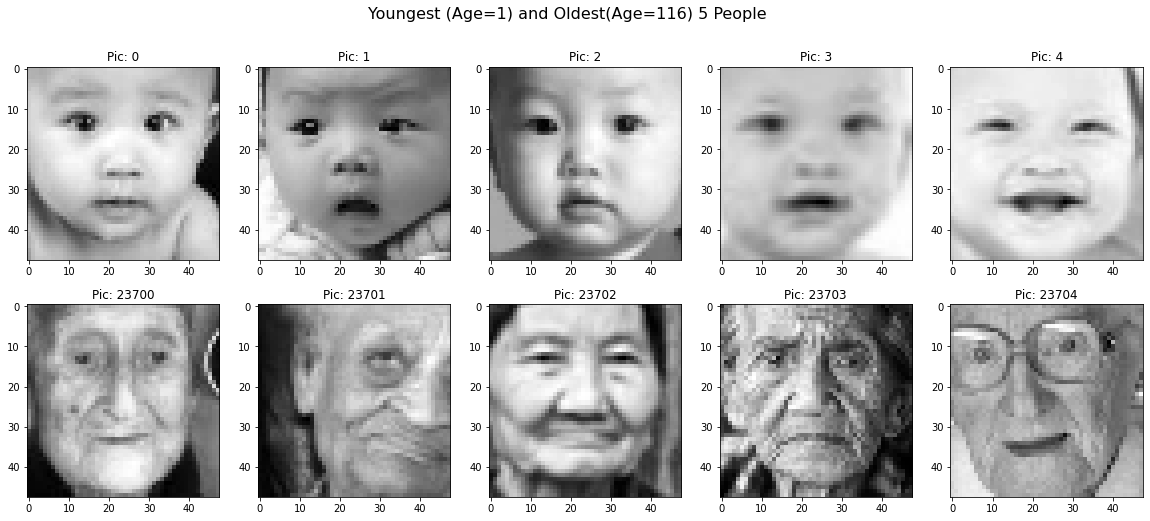

In [ ]:
_rows,_cols=2,5
fig, axs =  plt.subplots(_rows,_cols,figsize = (20,8))
fig.suptitle('Youngest (Age=1) and Oldest(Age=116) 5 People',size=16)
for i in range(_rows):
    for j in range(_cols):
        axs[i,j].imshow(df.pixels[-i*5+j+i*df.shape[0]]) 
        axs[i,j].set_title(f'Pic: {-i*5+j+i*df.shape[0]}')

In [ ]:
nums=np.random.randint(1,df.shape[0],10)
nums

array([17337,  6514, 19772,  5594, 13811,  2185, 16899, 20428, 23250,
       11008])

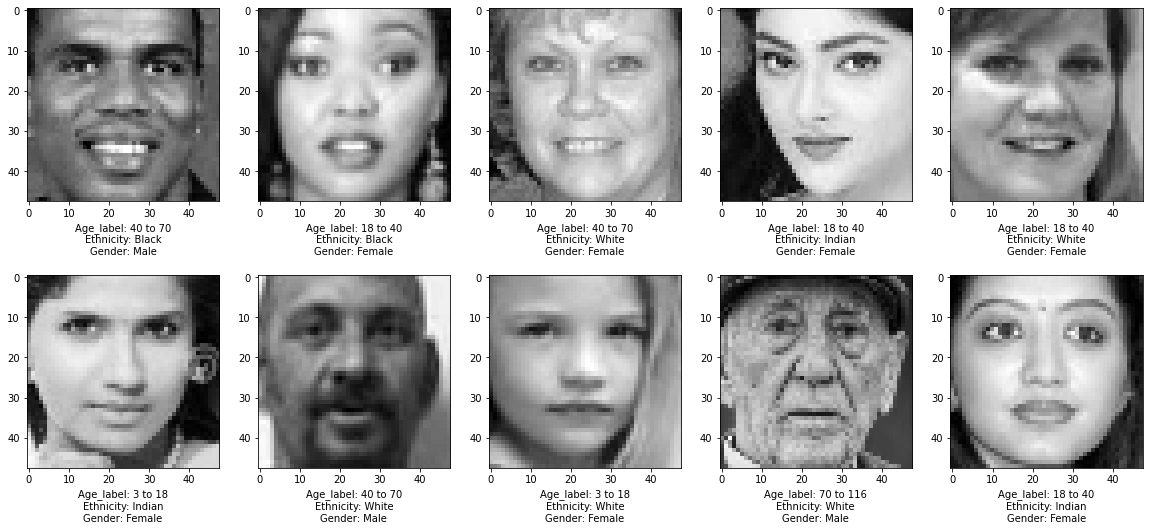

In [ ]:
plt.figure(figsize=(20,9))
for i,n in zip(range(10),nums):
  plt.subplot(2,5,i+1)
  plt.imshow(df.pixels[n],cmap='gray')
  plt.xlabel(f'Age_label: {df.loc[n,"age_labels"]}\nEthnicity: {df.loc[n,"ethnicity_labels"]}\nGender: {df.loc[n,"gender_labels"]}')

let's Try some Image Processing To make it better -- Hard

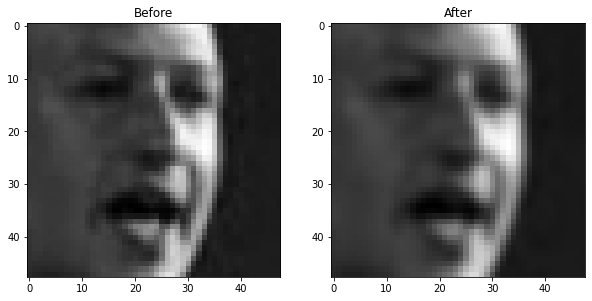

In [ ]:
plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.title("Before")

plt.imshow(df.pixels[7598],cmap='gray')
plt.subplot(1,2,2)

plt.title("After")

plt.imshow(gaussian(df.pixels[7598],multichannel=False,truncate=0.6 ),cmap='gray')

In [ ]:
def convert (img):
  # plt.figure(figsize=(8,8))
  # plt.subplot(1,2,1)
  # plt.title("before")
  # print(plt.imshow(img,cmap='gray'))

  img=equalize_hist(img)
  img=gaussian(img,multichannel=True,sigma=0.5,truncate=3.7)

  # plt.subplot(1,2,2)
  # plt.title("after")
  # print(plt.imshow(img,cmap='gray'))
  return np.array(img)


In [ ]:
# Applying our image processing
# df.pixels=df.pixels.apply(lambda x: convert(x))

In [ ]:
df.pixels[100]

array([[157., 175., 186., ...,  52., 139., 167.],
       [168., 184., 196., ...,   8.,  93., 140.],
       [179., 191., 199., ...,   6.,  42., 141.],
       ...,
       [ 48.,  53.,  63., ..., 191., 199., 230.],
       [128., 141., 146., ..., 193., 195., 229.],
       [182., 178., 171., ..., 191., 192., 224.]])

In [ ]:
#todo
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# datagen = ImageDataGenerator(
#         featurewise_center=False,  # set input mean to 0 over the dataset
#         samplewise_center=False,  # set each sample mean to 0
#         featurewise_std_normalization=False,  # divide inputs by std of the dataset
#         samplewise_std_normalization=False,  # divide each input by its std
#         zca_whitening=False,  # dimesion reduction
#         rotation_range=5,  # randomly rotate images in the range 5 degrees
#         zoom_range = 0.1, # Randomly zoom image 10%
#         width_shift_range=0.1,  # randomly shift images horizontally 10%
#         height_shift_range=0.1,  # randomly shift images vertically 10%
#         horizontal_flip=False,  # randomly flip images
#         vertical_flip=False)  # randomly flip images

# datagen.fit(x_test,x_train.all())


Data Preprocessing

In [ ]:
age_classes=len(list(df['age'].value_counts()))
ethnicity_classes=len(list(df['ethnicity'].value_counts()))
gender_classes=len(list(df['gender'].value_counts()))

Train and split the data --easy

In [ ]:
x_scaled=np.stack(df['pixels'])/255 if df.pixels[0].max()>1 else np.stack(df['pixels'])
x=x_scaled.reshape(df['pixels'].shape[0],h,w,1)
y_age=to_categorical(np.array(df['age']),age_classes)
y_ethnicity=to_categorical(np.array(df['ethnicity']),ethnicity_classes)
y_gender=to_categorical(np.array(df['gender']),gender_classes)

In [ ]:
def help_split(y,x=x):
  x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state = 1)
  return x_train,x_test,y_train,y_test

In [ ]:
x_train_age      ,x_test_age      ,y_train_age      ,y_test_age      =help_split(y_age)
x_train_ethnicity,x_test_ethnicity,y_train_ethnicity,y_test_ethnicity=help_split(y_ethnicity)
x_train_gender   ,x_test_gender   ,y_train_gender   ,y_test_gender   =help_split(y_gender)

Make CNN Model

In [ ]:
# defining the model
# from tensorflow.keras.applications import ResNet50V2
# from tensorflow.keras.layers import Input

class target_models:
    # back_bone=ResNet50V2(
    #     input_shape=(48,48,3),
    #     include_top=False
    # )

    @staticmethod
    def age_model(num_classes):
        model=Sequential()
        model.add(Conv2D(filters=32,kernel_size=(2,2),input_shape=(48,48,1),activation='relu'))
        model.add(MaxPool2D(pool_size=(2,2)))
        model.add(Conv2D(filters=32,kernel_size=(2,2),input_shape=(48,48,1),activation='relu'))
        model.add(MaxPool2D(pool_size=(2,2)))
        model.add(Flatten())
        model.add(Dense(18,activation='relu'))
        model.add(Dense(num_classes,activation='softmax'))
        model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
        return model

    @staticmethod
    def ethnicity_model(num_classes):
        model=Sequential()
        model.add(Conv2D(filters=32,kernel_size=(2,2),input_shape=(48,48,1),activation='relu'))
        model.add(MaxPool2D(pool_size=(2,2)))
        model.add(Conv2D(filters=32,kernel_size=(2,2),input_shape=(48,48,1),activation='relu'))
        model.add(MaxPool2D(pool_size=(2,2)))
        model.add(Flatten())
        model.add(Dense(27,activation='relu'))
        model.add(Dense(num_classes,activation='softmax'))
        model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
        return model

    @staticmethod
    def gender_model(num_classes):
        model=Sequential()
        model.add(Conv2D(filters=32,kernel_size=(2,2),input_shape=(48,48,1),activation='relu'))
        model.add(MaxPool2D(pool_size=(2,2)))
        model.add(Conv2D(filters=32,kernel_size=(2,2),input_shape=(48,48,1),activation='relu'))
        model.add(MaxPool2D(pool_size=(2,2)))
        model.add(Flatten())
        model.add(Dense(27,activation='relu'))
        model.add(Dense(num_classes,activation='sigmoid'))
        model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
        return model

In [ ]:
early_stop=EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
age_model      =target_models.age_model(age_classes)
ethnicity_model=target_models.ethnicity_model(ethnicity_classes)
gender_model   =target_models.gender_model(gender_classes)

In [ ]:
age_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 47, 47, 32)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 32)        4128      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 3872)              0         
_________________________________________________________________
dense (Dense)                (None, 18)                69714     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 9

In [ ]:
age_model.fit(x_train_age,y_train_age,epochs=10,validation_data=(x_test_age,y_test_age),callbacks=[early_stop])

Epoch 1/10
593/593 [==============================] - 36s 58ms/step - loss: 1.0829 - accuracy: 0.5747 - val_loss: 0.9372 - val_accuracy: 0.6108
Epoch 2/10
593/593 [==============================] - 35s 58ms/step - loss: 0.8390 - accuracy: 0.6599 - val_loss: 0.7701 - val_accuracy: 0.6954
Epoch 3/10
593/593 [==============================] - 34s 58ms/step - loss: 0.7070 - accuracy: 0.7177 - val_loss: 0.6944 - val_accuracy: 0.7311
Epoch 4/10
593/593 [==============================] - 34s 58ms/step - loss: 0.6516 - accuracy: 0.7402 - val_loss: 0.6480 - val_accuracy: 0.7469
Epoch 5/10
593/593 [==============================] - 34s 58ms/step - loss: 0.6073 - accuracy: 0.7573 - val_loss: 0.6512 - val_accuracy: 0.7435
Epoch 6/10
593/593 [==============================] - 35s 58ms/step - loss: 0.5780 - accuracy: 0.7696 - val_loss: 0.6419 - val_accuracy: 0.7460
Epoch 7/10
593/593 [==============================] - 35s 58ms/step - loss: 0.5550 - accuracy: 0.7802 - val_loss: 0.6375 - val_accuracy:

In [ ]:
age_losses=pd.DataFrame(age_model.history.history)

In [ ]:
ethnicity_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 47, 47, 32)        160       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 32)        4128      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3872)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 27)                104571    
_________________________________________________________________
dense_3 (Dense)              (None, 5)                

In [ ]:
ethnicity_model.fit(x_train_ethnicity,y_train_ethnicity,epochs=10,validation_data=(x_test_ethnicity,y_test_ethnicity),callbacks=[early_stop])

Epoch 1/10
593/593 [==============================] - 35s 58ms/step - loss: 1.1519 - accuracy: 0.5611 - val_loss: 0.9374 - val_accuracy: 0.6579
Epoch 2/10
593/593 [==============================] - 34s 57ms/step - loss: 0.8801 - accuracy: 0.6869 - val_loss: 0.8378 - val_accuracy: 0.7030
Epoch 3/10
593/593 [==============================] - 34s 57ms/step - loss: 0.7902 - accuracy: 0.7231 - val_loss: 0.7747 - val_accuracy: 0.7262
Epoch 4/10
593/593 [==============================] - 34s 58ms/step - loss: 0.7463 - accuracy: 0.7375 - val_loss: 0.7712 - val_accuracy: 0.7309
Epoch 5/10
593/593 [==============================] - 34s 58ms/step - loss: 0.7088 - accuracy: 0.7554 - val_loss: 0.7167 - val_accuracy: 0.7555
Epoch 6/10
593/593 [==============================] - 34s 57ms/step - loss: 0.6775 - accuracy: 0.7638 - val_loss: 0.7318 - val_accuracy: 0.7479
Epoch 7/10
593/593 [==============================] - 34s 57ms/step - loss: 0.6472 - accuracy: 0.7744 - val_loss: 0.6919 - val_accuracy:

In [ ]:
ethnicity_losses=pd.DataFrame(ethnicity_model.history.history)

In [ ]:
gender_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 47, 47, 32)        160       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 22, 22, 32)        4128      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3872)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 27)                104571    
_________________________________________________________________
dense_5 (Dense)              (None, 2)                

In [ ]:
gender_model.fit(x_train_gender,y_train_gender,epochs=10,validation_data=(x_test_gender,y_test_gender),callbacks=[early_stop])

Epoch 1/10
593/593 [==============================] - 35s 58ms/step - loss: 0.4834 - accuracy: 0.7635 - val_loss: 0.3762 - val_accuracy: 0.8302
Epoch 2/10
593/593 [==============================] - 34s 58ms/step - loss: 0.3530 - accuracy: 0.8453 - val_loss: 0.3289 - val_accuracy: 0.8498
Epoch 3/10
593/593 [==============================] - 34s 58ms/step - loss: 0.3132 - accuracy: 0.8663 - val_loss: 0.3061 - val_accuracy: 0.8627
Epoch 4/10
593/593 [==============================] - 34s 58ms/step - loss: 0.2881 - accuracy: 0.8756 - val_loss: 0.2855 - val_accuracy: 0.8743
Epoch 5/10
593/593 [==============================] - 34s 58ms/step - loss: 0.2742 - accuracy: 0.8819 - val_loss: 0.2741 - val_accuracy: 0.8817
Epoch 6/10
593/593 [==============================] - 34s 58ms/step - loss: 0.2577 - accuracy: 0.8906 - val_loss: 0.2708 - val_accuracy: 0.8844
Epoch 7/10
593/593 [==============================] - 34s 57ms/step - loss: 0.2458 - accuracy: 0.8957 - val_loss: 0.2579 - val_accuracy:

In [ ]:
gender_losses=pd.DataFrame(gender_model.history.history)

After Training

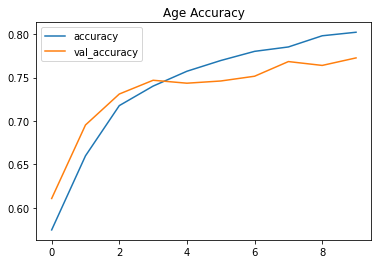

In [ ]:
age_losses[['accuracy','val_accuracy']].plot(title='Age Accuracy')

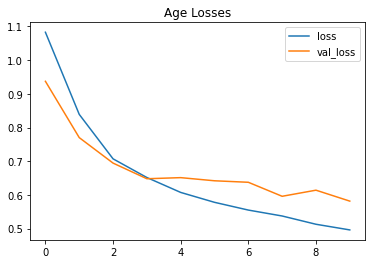

In [ ]:
age_losses[['loss','val_loss']].plot(title='Age Losses')

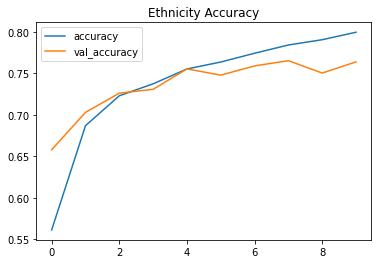

In [ ]:
ethnicity_losses[['accuracy','val_accuracy']].plot(title='Ethnicity Accuracy')

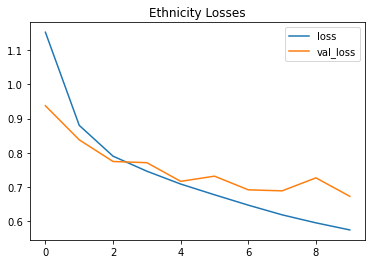

In [ ]:
ethnicity_losses[['loss','val_loss']].plot(title='Ethnicity Losses')

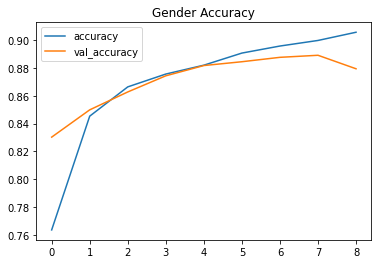

In [ ]:
gender_losses[['accuracy','val_accuracy']].plot(title='Gender Accuracy')

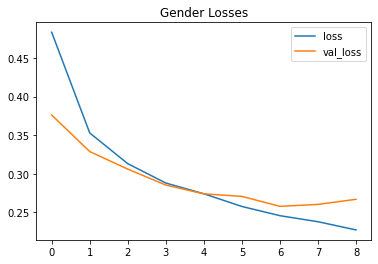

In [ ]:
gender_losses[['loss','val_loss']].plot(title='Gender Losses')

Make Predictions

In [ ]:
y_test_age

array([[0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [ ]:
# y_test_age_labels=np.array([np.argmax(y,axis=None,out=None) for y in y_test_age])
# y_test_age_labels

In [ ]:
y_test_ethnicity

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [ ]:
y_test_ethnicity

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [ ]:
y_test_age

array([[0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [ ]:
x_test_age.shape

(4741, 48, 48, 1)

In [ ]:
age_model.predict(x_test_age)

array([[1.70543672e-07, 1.41522463e-03, 9.90905166e-01, 7.57775642e-03,
        1.01676014e-04],
       [9.26571846e-01, 7.31667429e-02, 2.20868460e-04, 3.93697228e-05,
        1.18836044e-06],
       [5.84811005e-06, 8.34446400e-02, 8.91698480e-01, 2.48454399e-02,
        5.58577358e-06],
       ...,
       [1.78926111e-05, 3.98686863e-02, 9.22455549e-01, 3.75854112e-02,
        7.24180281e-05],
       [9.92043912e-01, 7.93389138e-03, 1.87661972e-05, 3.13424175e-06,
        2.22314924e-07],
       [1.76980257e-06, 9.93074209e-05, 1.02975346e-01, 8.93367648e-01,
        3.55598424e-03]], dtype=float32)

In [ ]:
y_test_age_labels=np.array([np.argmax(y,axis=None,out=None) for y in y_test_age])
y_test_ethnicity_labels=np.array([np.argmax(y,axis=None,out=None) for y in y_test_ethnicity])
y_test_gender_labels=np.array([np.argmax(y,axis=None,out=None) for y in y_test_gender])

In [ ]:
y_test_age_labels

array([2, 0, 2, ..., 2, 0, 3])

In [ ]:
age_predictions=np.argmax(age_model.predict(x_test_age),axis=-1)
ethnicity_predictions=np.argmax(ethnicity_model.predict(x_test_ethnicity),axis=-1)
gender_predictions=np.argmax(gender_model.predict(x_test_gender),axis=-1)

In [ ]:
plt.figure(figsize=(10,10))
age_mat=confusion_matrix(y_test_age_labels, age_predictions)
sns.heatmap(age_mat,
            annot=True, 
            cmap='Accen',
            fmt='g',
            xticklabels=age_labels.values(),
            yticklabels=age_labels.values()).set(title='age Confusion Matrix')

ValueError: ignored

<Figure size 720x720 with 0 Axes>

[Text(0.5, 1.0, 'Age Confusion Matrix')]

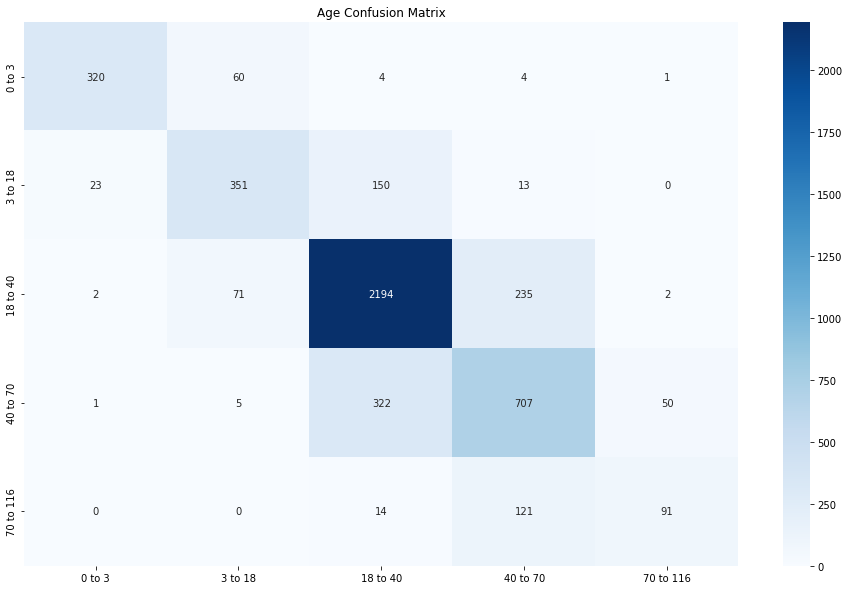

In [ ]:
plt.figure(figsize=(16,10))
age_mat=confusion_matrix(y_test_age_labels, age_predictions)
sns.heatmap(age_mat,
            annot=True, 
            cmap='Blues',
            fmt='g',
            xticklabels=age_labels.values(),
            yticklabels=age_labels.values()).set(title='Age Confusion Matrix')

Text(0.5, 1.0, 'Age Classification Report')

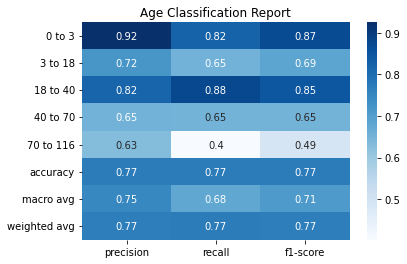

In [ ]:
age_clfr=classification_report(y_test_age_labels,age_predictions,target_names=age_labels.values(),output_dict=True)
sns.heatmap(pd.DataFrame(age_clfr).iloc[:-1, :].T, annot=True, cmap='Blues').set_title('Age Classification Report')

[Text(0.5, 1.0, 'Ethnicity Confusion Matrix')]

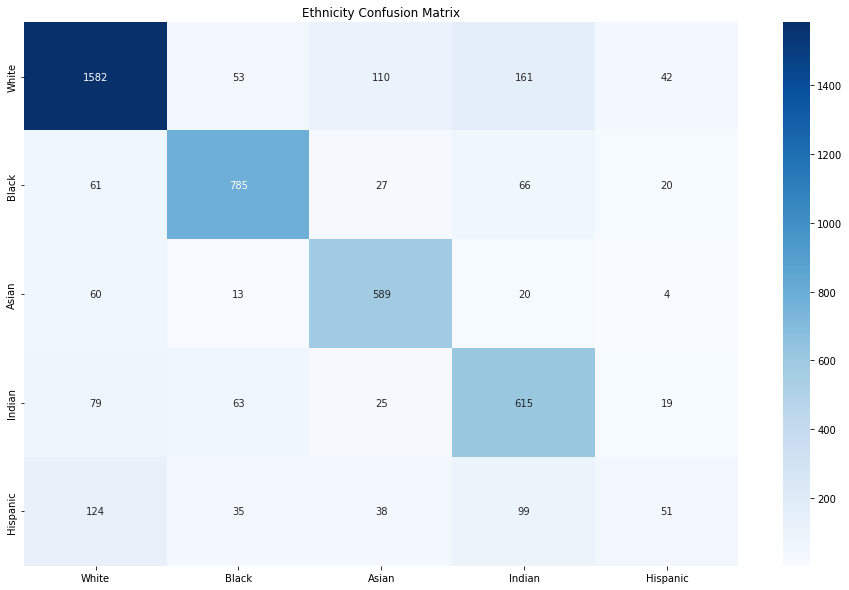

In [ ]:
plt.figure(figsize=(16,10))
ethnicity_mat=confusion_matrix(y_test_ethnicity_labels, ethnicity_predictions)
sns.heatmap(ethnicity_mat,
            annot=True, 
            cmap='Blues',
            fmt='g',
            xticklabels=ethnicity_labels.values(),
            yticklabels=ethnicity_labels.values()).set(title='Ethnicity Confusion Matrix')

Text(0.5, 1.0, 'Ethnicity Classification Report')

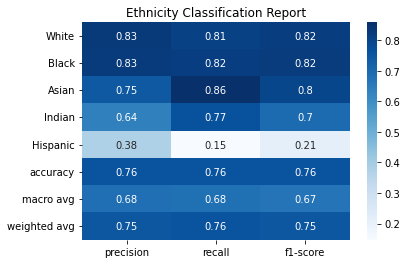

In [ ]:
ethnicity_clfr=classification_report(y_test_ethnicity_labels,ethnicity_predictions,target_names=ethnicity_labels.values(),output_dict=True)
sns.heatmap(pd.DataFrame(ethnicity_clfr).iloc[:-1, :].T, annot=True, cmap='Blues').set_title('Ethnicity Classification Report')

[Text(0.5, 1.0, 'Gender Confusion Matrix')]

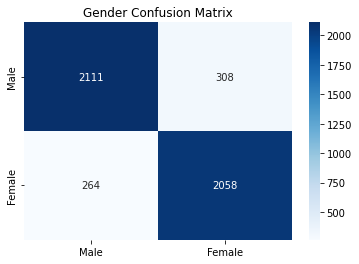

In [ ]:
gender_mat=confusion_matrix(y_test_gender_labels, gender_predictions)
sns.heatmap(gender_mat,
            annot=True, 
            cmap='Blues',
            fmt='g',
            xticklabels=gender_labels.values(),
            yticklabels=gender_labels.values()).set(title='Gender Confusion Matrix')

Text(0.5, 1.0, 'Gender Classification Report')

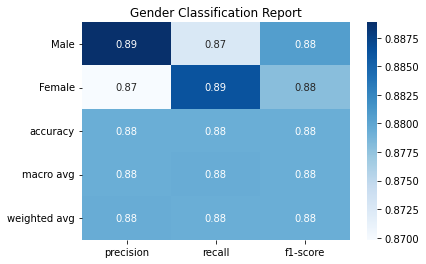

In [ ]:
gender_clfr=classification_report(y_test_gender_labels,gender_predictions,target_names=gender_labels.values(),output_dict=True)
sns.heatmap(pd.DataFrame(gender_clfr).iloc[:-1, :].T, annot=True, cmap='Blues').set_title('Gender Classification Report')

In [ ]:
# def show_predict(i,pred_age=age_predictions,pred_ethnicity=ethnicity_predictions,pred_gender=gender_predictions)
#   for i in args:

age_model.predict(df.pixels[1].reshape(48,48,1))
# i=1111
# real_age            =df.loc[[i]]['age_labels']
# age_label_pred      =age_labels[age_model.predict(df.loc[[i]])]
# real_ethnicity      =df.loc[[i]]['ethnicity_labels']
# ethnicity_label_pred=ethnicity_labels[ethnicity_model.predict(df.loc[[i]])]
# real_gender         =df.loc[[i]]['gender_labels']
# gender_label_pred   =gender_lables[gender_model.predict(df.loc[[i]])]
# plt.imshow(df.pixels[i])
# plt.xlabel(f'Predictions:\n Age:{age_label_pred}, Ethnicity: {ethnicity_label_pred}, Gender: {gender_label_pred}')

In [ ]:
#todo accept any image for any where to make a prediction

In [ ]:
def f_predict(img_path,age_model=age_model,ethnicity_model=ethnicity_model,gender_model=gender_model):
  img=tf.keras.utils.load_img(img_path,target_size=(48,48))
  # img_toshow=tf.keras.utils.load_img(img_path)
  plt.imshow(img)
  img=tf.keras.utils.img_to_array(img)
  img=np.expand_dims(img, axis=0)
  img/=255
  img=rgb2gray(img).reshape(1,48,48,1)
  age_pred=age_model.predict(img)
  ethnicity_pred=ethnicity_model.predict(img)
  gender_pred=gender_model.predict(img)
  age_label=np.argsort(age_pred)
  gender_label=np.argsort(gender_pred)
  ethnicity_label=np.argsort(ethnicity_pred)
  for i in age_label[0][::-1][:2]:
    print(f'Age: {age_labels[i]}: {age_pred[0][i]*100:0.2f} %')
  for i in ethnicity_label[0][::-1][:2]:
    print(f'Ethnicity: {ethnicity_labels[i]}: {ethnicity_pred[0][i]*100:0.2f} %')
  for i in gender_label[0][::-1][:1]:
    print(f'Gender: {gender_labels[i]}: {gender_pred[0][i]*100:0.2f} %')



  # for i in age_label[0][-1:-3:-1]:
  #     print(f'Age: {age_labels[i]}: {age_pred[0][i]*100:0.2f} %')
  #     print(f'Ethnicity: {ethnicity_labels[i]}: {ethnicity_pred[0][i]*100:0.2f} %')
  #     print(f'Gender: {gender_labels[i]}: {gender_pred[0][i]*100:0.2f} %')

Age: 18 to 40: 99.58 %
Age: 40 to 70: 0.32 %
Ethnicity: White: 68.83 %
Ethnicity: Asian: 29.61 %
Gender: Male: 99.03 %


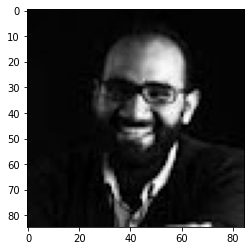

In [ ]:
f_predict('/content/gehadd].jpg')

In [ ]:
!wget https://i.pinimg.com/originals/de/04/9b/de049bf71947406f51000e82bbd85879.jpg

--2021-09-24 20:15:30--  https://i.pinimg.com/originals/de/04/9b/de049bf71947406f51000e82bbd85879.jpg
Resolving i.pinimg.com (i.pinimg.com)... 151.101.188.84, 2a04:4e42:2d::84
Connecting to i.pinimg.com (i.pinimg.com)|151.101.188.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13836 (14K) [image/jpeg]
Saving to: ‘de049bf71947406f51000e82bbd85879.jpg.3’

de049bf71947406f510 100%[===================>]  13.51K  --.-KB/s    in 0s      

2021-09-24 20:15:30 (81.0 MB/s) - ‘de049bf71947406f51000e82bbd85879.jpg.3’ saved [13836/13836]



Age: 18 to 40: 73.49 %
Age: 0 to 3: 18.47 %
Ethnicity: White: 42.13 %
Ethnicity: Asian: 24.19 %
Gender: Male: 99.98 %


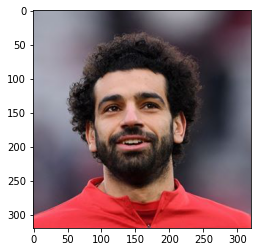

In [ ]:
f_predict('./de049bf71947406f51000e82bbd85879.jpg.3')